In [11]:
!wget https://raw.githubusercontent.com/thecopy-cat/7135CEM-Modeling-and-Optimisation/main/Task%201/Dataset.csv

--2024-07-26 05:05:52--  https://raw.githubusercontent.com/thecopy-cat/7135CEM-Modeling-and-Optimisation/main/Task%201/Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18386219 (18M) [text/plain]
Saving to: ‘Dataset.csv.7’

Dataset.csv.7       100%[===================>]  17.53M  --.-KB/s    in 0.1s    

2024-07-26 05:05:52 (118 MB/s) - ‘Dataset.csv.7’ saved [18386219/18386219]



In [12]:
!pip install --upgrade gensim
!pip install pyldavis
!pip install gensim

In [14]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import spacy

# gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
#from pyLDAvis import gensim_models as pg
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/thecopy-cat/7135CEM-Modeling-and-Optimisation/main/Task%201/Dataset.csv')
print(df.shape)
df.head()

(1597, 27)


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [16]:
# filter for product id = amazon echo
df = df.query("asins == 'B01BH83OOM'")
print(df.shape)
df.head()

(542, 27)


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


In [17]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


# convert to list
data = df['reviews.text'].to_list()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


In [18]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
import nltk
from nltk.corpus import stopwords
import string

# Download the 'stopwords' corpus
nltk.download('stopwords')

stop_words = stopwords.words('english') + list(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
import string
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(string.punctuation)

In [20]:
def remove_stopwords(texts):
    result = []
    for doc in texts:
        processed_doc = []
        for word in simple_preprocess(str(doc)):
            if word not in stop_words:
                processed_doc.append(word)
        result.append(processed_doc)
    return result

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        lemmas = []
        for token in doc:
            if token.pos_ in allowed_postags:
                lemmas.append(token.lemma_)
        texts_out.append(lemmas)
    return texts_out

In [22]:
# remove stop words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en' model, use only tagger since we don't need parsing or NER
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'speaker', 'second', 'big', 'reason', 'buy', 'standard', 'wifi', 'streaming', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'microphone', 'button', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [23]:
# compare the nostop, lemmatised version with the original one
# note that speakers is lemmatised to speaker; index = 3
# Index of the review to compare

original_review = ' '.join(data_words[3])
lemmatized_review = ' '.join(data_lemmatized[3])

print("Original Review:\n", original_review, "\n")
print("Lemmatized Review:\n", lemmatized_review)

Original Review:
 look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

Lemmatized Review:
 look product portable speaker second big reason buy standard wifi streaming enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap microphone button listen voice want big sound always listen feature spend extra money


In [27]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(3, 2), (13, 2), (16, 2), (17, 3), (20, 2), (24, 4), (29, 1), (31, 1), (35, 1), (48, 2), (51, 1), (56, 1), (60, 5), (70, 1), (82, 1), (85, 5), (88, 1), (90, 2), (95, 1), (96, 1), (97, 2), (99, 2), (100, 1), (108, 2), (112, 1), (116, 1), (120, 1), (128, 2), (131, 1), (134, 1), (141, 1), (142, 1), (143, 2), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 2), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 2), (164, 1), (165, 1), (166, 3), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 2), (180, 1), (181, 1), (182, 2), (183, 2), (184, 5), (185, 1), (186, 3), (187, 2), (188, 1), (189, 3), (190, 1), (191, 1), (192, 1), (193, 1), (194, 6), (195, 1), (196, 1), (197, 2), (198, 1), (199, 2), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 2), (207, 1), (208, 1), (209, 2), (210, 1)]


In [28]:
# human-readable format of corpus (term-frequency)
# Display term-frequency representation for the first document
for doc in corpus[:1]:
    for id, freq in doc:
        print(f"Word: {id2word[id]}, Frequency: {freq}")

Word: admit, Frequency: 1
Word: alexa, Frequency: 1
Word: allow, Frequency: 1
Word: amazon, Frequency: 1
Word: announce, Frequency: 1
Word: answer, Frequency: 1
Word: anyway, Frequency: 1
Word: app, Frequency: 2
Word: appealing, Frequency: 1
Word: associate, Frequency: 1
Word: avid, Frequency: 1
Word: aware, Frequency: 1
Word: back, Frequency: 1
Word: battery, Frequency: 3
Word: buy, Frequency: 1
Word: choose, Frequency: 2
Word: command, Frequency: 1
Word: control, Frequency: 1
Word: convenience, Frequency: 1
Word: cook, Frequency: 1
Word: day, Frequency: 1
Word: decide, Frequency: 2
Word: demand, Frequency: 1
Word: development, Frequency: 1
Word: device, Frequency: 3
Word: dot, Frequency: 1
Word: drain, Frequency: 1
Word: early, Frequency: 2
Word: easily, Frequency: 2
Word: echo, Frequency: 1
Word: enable, Frequency: 1
Word: especially, Frequency: 1
Word: fabulous, Frequency: 1
Word: financial, Frequency: 1
Word: firmware, Frequency: 1
Word: first, Frequency: 1
Word: free, Frequency: 

In [29]:
# help(gensim.models.ldamodel.LdaModel)

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=10, random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [31]:
# Build LDA model
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [32]:
# Display the 10 topics
for topic in lda_model.print_topics():
    print(topic)

# Infer topic distribution for each document
document_topics = lda_model[corpus]

(0, '0.068*"amazing" + 0.033*"easy" + 0.031*"little" + 0.030*"super" + 0.026*"sync" + 0.024*"able" + 0.022*"beach" + 0.021*"weather" + 0.017*"difficult" + 0.016*"assistant"')
(1, '0.061*"easy" + 0.057*"sound" + 0.043*"portability" + 0.038*"buy" + 0.037*"echo" + 0.035*"feature" + 0.028*"house" + 0.028*"quality" + 0.020*"need" + 0.020*"room"')
(2, '0.064*"loud" + 0.044*"decent" + 0.042*"expensive" + 0.035*"capability" + 0.031*"glad" + 0.023*"upgrade" + 0.022*"mother" + 0.018*"issue" + 0.015*"size" + 0.015*"online"')
(3, '0.043*"enjoy" + 0.039*"talk" + 0.033*"button" + 0.030*"alexa" + 0.024*"thing" + 0.024*"fun" + 0.022*"put" + 0.021*"tap" + 0.020*"hold" + 0.020*"lot"')
(4, '0.057*"great" + 0.048*"speaker" + 0.043*"use" + 0.037*"sound" + 0.035*"tap" + 0.032*"love" + 0.031*"good" + 0.031*"music" + 0.028*"alexa" + 0.026*"work"')
(5, '0.070*"set" + 0.037*"start" + 0.034*"actually" + 0.030*"radio" + 0.027*"come" + 0.027*"new" + 0.018*"station" + 0.017*"week" + 0.016*"ago" + 0.016*"enjoy"')
(6

In [33]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4395692084830964


In [34]:
# Enable pyLDAvis in notebook
pyLDAvis.enable_notebook()

# Prepare visualization data
visualization_data = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

# Display the visualization
visualization_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.323406 -0.008689       1        1  46.543196
6      0.002890 -0.143587       2        1  14.356977
9      0.047303 -0.145590       3        1  11.812837
1      0.158946  0.255861       4        1   9.647423
3      0.068182 -0.139447       5        1   7.020614
5     -0.122254  0.000295       6        1   3.472706
8     -0.098321  0.066386       7        1   2.434911
0     -0.125367  0.054601       8        1   1.986343
2     -0.131949  0.027343       9        1   1.878914
7     -0.122838  0.032827      10        1   0.846080, topic_info=        Term        Freq       Total Category  logprob  loglift
82     sound  199.000000  199.000000  Default  30.0000  30.0000
85       tap  249.000000  249.000000  Default  29.0000  29.0000
52      love  156.000000  156.000000  Default  28.0000  28.0000
388     easy   57.000000   57.000000  Default  27.0000  27.0000
194  speaker  196.000000  196.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
988  opposed    0.349115    1.034819  Topic10  -5.3524   3.6857
987    cloud    0.740884    2.680409  Topic10  -4.5999   3.4864
108     come    1.275888   10.097987  Topic10  -4.0564   2.7036
256   pretty    0.717054   19.660754  Topic10  -4.6326   1.4611
304     feel    0.435574    7.723698  Topic10  -5.1311   1.8969

[468 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
102       2  0.184422    ability
102       4  0.737686    ability
277       2  0.575168       able
277       3  0.301279       able
277       8  0.109556       able
...     ...       ...        ...
1316      6  0.887561  worldwide
307       1  0.944962      worth
141       5  0.634397       year
141       6  0.380638       year
679       5  0.860518        yet

[533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 10, 2, 4, 6, 9, 1, 3, 8])

In [35]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):

    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            # Use id2word instead of d2word
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
    return model_list, coherence_values

In [36]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        num_topics_range=num_topics_range,
                                                        alpha_range=alpha_range)

In [37]:
import pandas as pd
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.466255
1,0.01,6,0.430375
2,0.01,10,0.431626
3,0.01,15,0.411725
4,0.01,20,0.406056
5,0.10,2,0.479757
6,0.10,6,0.416840
7,0.10,10,0.427158
8,0.10,15,0.415724
9,0.10,20,0.381693


In [38]:
coherence_df.sort_values('coherence_value')

,alpha,num_topics,coherence_value
9,0.10,20,0.381693
4,0.01,20,0.406056
3,0.01,15,0.411725
8,0.10,15,0.415724
6,0.10,6,0.416840
7,0.10,10,0.427158
1,0.01,6,0.430375
2,0.01,10,0.431626
11,1.00,6,0.462126
12,1.00,10,0.464386


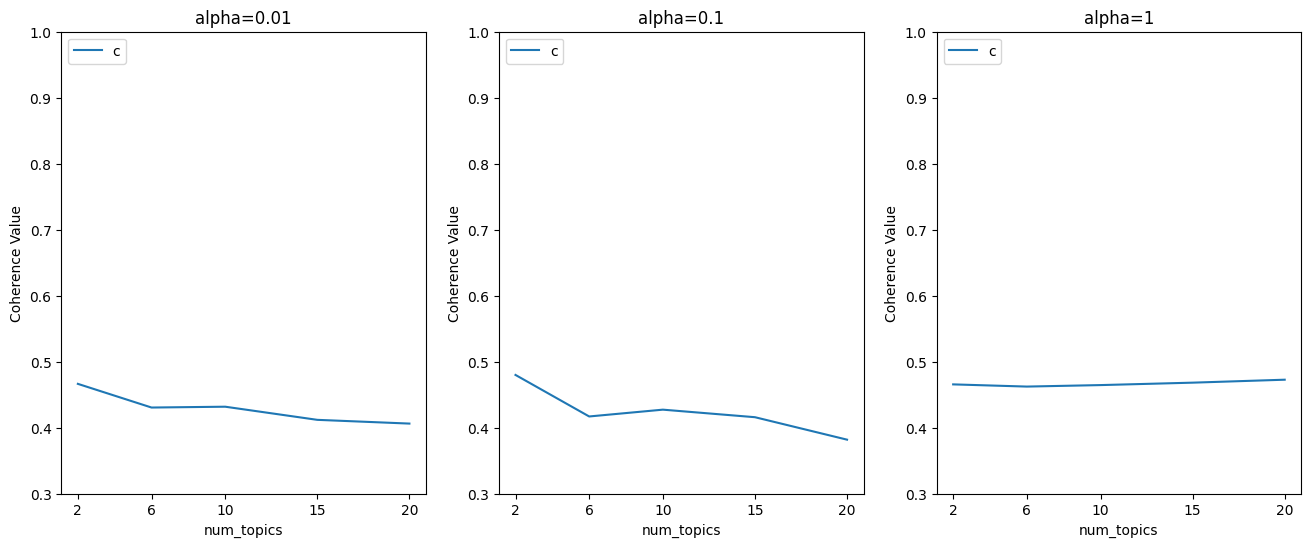

In [39]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)

In [40]:
#Finally building the LDA Model by selecting

Final_LDA_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=6,
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha=1,
                                                  per_word_topics=True)

In [41]:
# Display topics
for topic in Final_LDA_model.print_topics():
    print(topic)

# Get topic distribution for each document
doc_topics = Final_LDA_model[corpus]

(0, '0.068*"use" + 0.029*"enjoy" + 0.026*"able" + 0.023*"question" + 0.021*"little" + 0.018*"hand" + 0.016*"app" + 0.015*"free" + 0.015*"ask" + 0.014*"alexa"')
(1, '0.112*"sound" + 0.066*"great" + 0.057*"good" + 0.040*"quality" + 0.026*"speaker" + 0.025*"easy" + 0.024*"well" + 0.023*"alexa" + 0.018*"price" + 0.017*"portability"')
(2, '0.120*"love" + 0.078*"buy" + 0.048*"great" + 0.045*"use" + 0.042*"product" + 0.040*"music" + 0.034*"play" + 0.025*"gift" + 0.016*"fun" + 0.015*"lot"')
(3, '0.057*"get" + 0.054*"tap" + 0.043*"portable" + 0.037*"work" + 0.036*"alexa" + 0.034*"echo" + 0.031*"dot" + 0.030*"button" + 0.026*"speaker" + 0.023*"listen"')
(4, '0.049*"speaker" + 0.027*"voice" + 0.025*"music" + 0.025*"connect" + 0.024*"time" + 0.023*"phone" + 0.021*"wifi" + 0.020*"device" + 0.017*"say" + 0.017*"also"')
(5, '0.073*"tap" + 0.022*"make" + 0.020*"purchase" + 0.019*"excellent" + 0.017*"add" + 0.017*"even" + 0.015*"home" + 0.015*"weather" + 0.014*"item" + 0.014*"thing"')


In [42]:
# Calculate coherence score
coherence_model = CoherenceModel(model=Final_LDA_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print('\nCoherence Score:', coherence_score)


Coherence Score: 0.4320839187148216


In [43]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Final_LDA_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.081173 -0.006321       1        1  20.086304
1      0.036347  0.272776       2        1  17.162601
3      0.209967 -0.022243       3        1  17.161972
5      0.006240 -0.130247       4        1  16.611203
0     -0.056148 -0.160560       5        1  16.030511
2     -0.277579  0.046594       6        1  12.947410, topic_info=            Term        Freq       Total Category  logprob  loglift
82         sound  169.000000  169.000000  Default  30.0000  30.0000
52          love  135.000000  135.000000  Default  29.0000  29.0000
14           buy   90.000000   90.000000  Default  28.0000  28.0000
85           tap  229.000000  229.000000  Default  27.0000  27.0000
96           use  179.000000  179.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
20           day    9.548646   22.288598   Topic6  -4.7717   1.1966
388         easy   15.345788   60.631937   Topic6  -4.2972   0.6703
283  portability   12.341176   42.046065   Topic6  -4.5151   0.8184
324    recommend    7.332341   30.299255   Topic6  -5.0358   0.6254
291     purchase    7.133955   36.795718   Topic6  -5.0632   0.4038

[321 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
277       3  0.121035        able
277       5  0.871452        able
417       6  0.836288  absolutely
143       1  0.979956    activate
590       2  0.917841  activation
...     ...       ...         ...
327       5  0.130796        work
327       6  0.054498        work
307       2  0.915539       worth
141       4  0.920513        year
679       6  0.770835         yet

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 6, 1, 3])